In [ ]:
from boxoffice.db.frames import get_movie_frame_full
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
from sklearn.metrics import root_mean_squared_error

df = get_movie_frame_full()

if df is None:
    print('No data')
    exit()
    

movies.csv exists, 1730583669.9247737, 1730583580.705396
Reading from movies.csv


In [22]:
# main goal is to predict opening_weekend_revenue

# do a train test split based on release date. Train on movies released before 2023, test on movies released in 2023 and 2024

# drop movies with missing budgets
df = df.dropna(subset=['budget'])

# drop the opening_weekend_revenue column
df = df.drop(columns=['opening_weekend_revenue'])

# filter out movies from before 2015    
df = df[df['release_day'] >= datetime.date(2015, 1, 1)]

# keep original columns for later
dummies = pd.get_dummies(df[['mpaa_rating', 'genre', 'creative_type', 'source', 'production_method', 'distributor_slug']], drop_first=True)
df = pd.concat([df, dummies], axis=1)

df['in_franchise'] = df['franchise_slug'].notnull().astype(int)

X_train = df[(df['release_day'] < datetime.date(2023, 1, 1))]
X_test = df[df['release_day'] >= datetime.date(2023, 1, 1)]

y_train = X_train['opening_wide_revenue']
y_test = X_test['opening_wide_revenue']

X_train = X_train.drop(columns=['opening_wide_revenue'])
X_test = X_test.drop(columns=['opening_wide_revenue'])

# reset index
X_train = X_train.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

In [4]:
# write the titles and ids of the movies with missing budget to a csv file
missing_budget = df[df['budget'].isnull()]
missing_budget[['title', 'id']].to_csv('missing_budget.csv', index=False)

In [23]:
# create a basic MLR
from statsmodels.api import OLS

# print the columns
# print(X_train.columns)

# create dummy variables for mpaa_rating, genre, creative_type, source, production_method, and distributor
# X_train_dummies = pd.get_dummies(X_train, columns=['mpaa_rating', 'genre', 'creative_type', 'source', 'production_method', 'distributor_slug'])

# print(X_train_dummies.columns)

# remove all non-numeric columns
X_train_dummies = X_train.select_dtypes(include=[np.number, bool])

# remove franchise id and distributor id and id
X_train_dummies = X_train_dummies.drop(columns=['franchise_id', 'distributor_id', 'id'])

# drop preview_sum and preview_to_weekend_ratio
X_train_dummies = X_train_dummies.drop(columns=['preview_sum', 'preview_to_weekend_ratio', 'first_five_days_revenue', 'first_seven_days_revenue', 'total_revenue_within_365_days', 'opening_weekend_to_total_ratio', 'fri_sat_ratio_first_five', 'sat_sun_ratio_first_five', 'sun_mon_ratio_first_five', 'mon_tue_ratio_first_five', 'tue_wed_ratio_first_five', 'wed_thu_ratio_first_five', 'thu_fri_ratio_first_five', 'fri_sat_ratio', 'sat_sun_ratio', 'sun_mon_ratio', 'mon_tue_ratio', 'tue_wed_ratio', 'wed_thu_ratio', 'thu_fri_ratio', 'total_box_office', 'largest_theater_count', 'days_over_1000_theaters', 'days_over_1000000_revenue', 'days_over_100000_revenue', 'wikipedia_cumulative_views'])

X_train_dummies = X_train_dummies.fillna(0)

# print the columns that have NaN values
print(X_train_dummies.columns[X_train_dummies.isna().any()])

# Ensure all data is numeric
X_train_dummies = X_train_dummies.astype(float)

model = OLS(y_train, X_train_dummies)
results = model.fit()

# print the summary with millions of dollars
def millions(x):
    return '{:,.2f}M'.format(x / 1000000)

print(results.summary2(float_format=millions))


Index([], dtype='object')
                                                Results: Ordinary least squares
Model:                                  OLS                                Adj. R-squared (uncentered):               0.846     
Dependent Variable:                     opening_wide_revenue               AIC:                                       26882.5367
Date:                                   2024-11-02 17:41                   BIC:                                       27379.6162
No. Observations:                       737                                Log-Likelihood:                            -13333.   
Df Model:                               108                                F-statistic:                               38.52     
Df Residuals:                           629                                Prob (F-statistic):                        1.34e-216 
R-squared (uncentered):                 0.869                              Scale:                                     3.

In [6]:
# now do lasso
from sklearn.linear_model import Lasso, LassoCV
from sklearn.model_selection import RepeatedKFold

cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)

lasso = LassoCV(cv=cv, n_alphas=100, random_state=1)

lasso.fit(X_train_dummies, y_train)

print('Best alpha:', lasso.alpha_)
print('Number of non-zero coefficients:', np.sum(lasso.coef_ != 0))
# print the coefficients

# match up the coefficients with the column names
coefficients = pd.DataFrame({'feature': X_train_dummies.columns, 'coefficient': lasso.coef_})
# remove the columns with 0 coefficients
coefficients = coefficients[coefficients['coefficient'] != 0]

print(coefficients)

# print the r squared value
print('R squared:', lasso.score(X_train_dummies, y_train))


Best alpha: 1956845794746.6177
Number of non-zero coefficients: 7
                                   feature  coefficient
2                                   budget     0.207456
13              director_median_box_office    -0.267698
14                director_mean_box_office     0.205308
15         weighted_crew_median_box_office     0.828076
17         weighted_cast_median_box_office    -0.142053
18           weighted_cast_mean_box_office     0.408910
19  wikipedia_pre_release_cumulative_views    13.912162
R squared: 0.6947194412842213


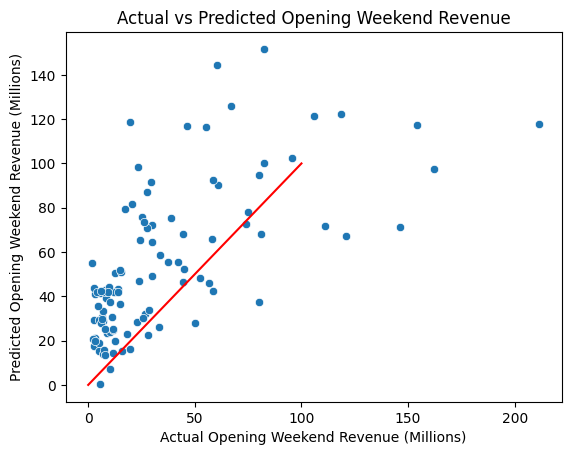

In [24]:
# now run the new model on the test data
# don't need to create dummy variables and stuff since only some variables are significant
def calculate_prediction(coefficients_df, row):
    pred_sum = 0
    for index, coef_row in coefficients_df.iterrows():
        feature = coef_row['feature']
        coefficient = coef_row['coefficient']

        pred_sum += coefficient * row[feature]

    return pred_sum

def make_predictions(coefficients_df, X):
    return X.apply(lambda x: calculate_prediction(coefficients_df, x), axis=1)

# within X_test 0 fill all NaN values
X_test = X_test.fillna(0)

y_pred = make_predictions(coefficients, X_test)

# make a results df with the names and then the values in millions
results_df = pd.DataFrame({'title': X_test['title'], 'predicted': y_pred, 'actual': y_test})
results_df['predicted'] = results_df['predicted'] / 1000000
results_df['actual'] = results_df['actual'] / 1000000

results_df.to_csv('lasso_results.csv', index=False)

# make a scatter plot of the predicted vs actual
sns.scatterplot(x='actual', y='predicted', data=results_df)
plt.xlabel('Actual Opening Weekend Revenue (Millions)')
plt.ylabel('Predicted Opening Weekend Revenue (Millions)')
plt.title('Actual vs Predicted Opening Weekend Revenue')

# make a line of y=x
plt.plot([0, 100], [0, 100], color='red')

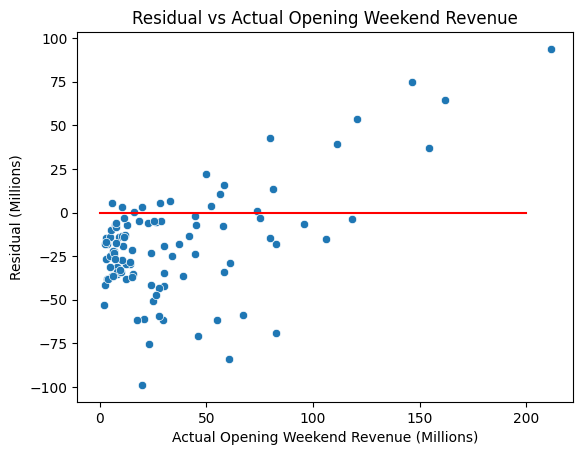

In [25]:
# plot the residuals
results_df['residual'] = results_df['actual'] - results_df['predicted']
sns.scatterplot(x='actual', y='residual', data=results_df)
plt.xlabel('Actual Opening Weekend Revenue (Millions)')
plt.ylabel('Residual (Millions)')
plt.title('Residual vs Actual Opening Weekend Revenue')

# line at y=0
plt.plot([0, 200], [0, 0], color='red')

<Axes: xlabel='wikipedia_pre_release_cumulative_views', ylabel='opening_wide_revenue'>

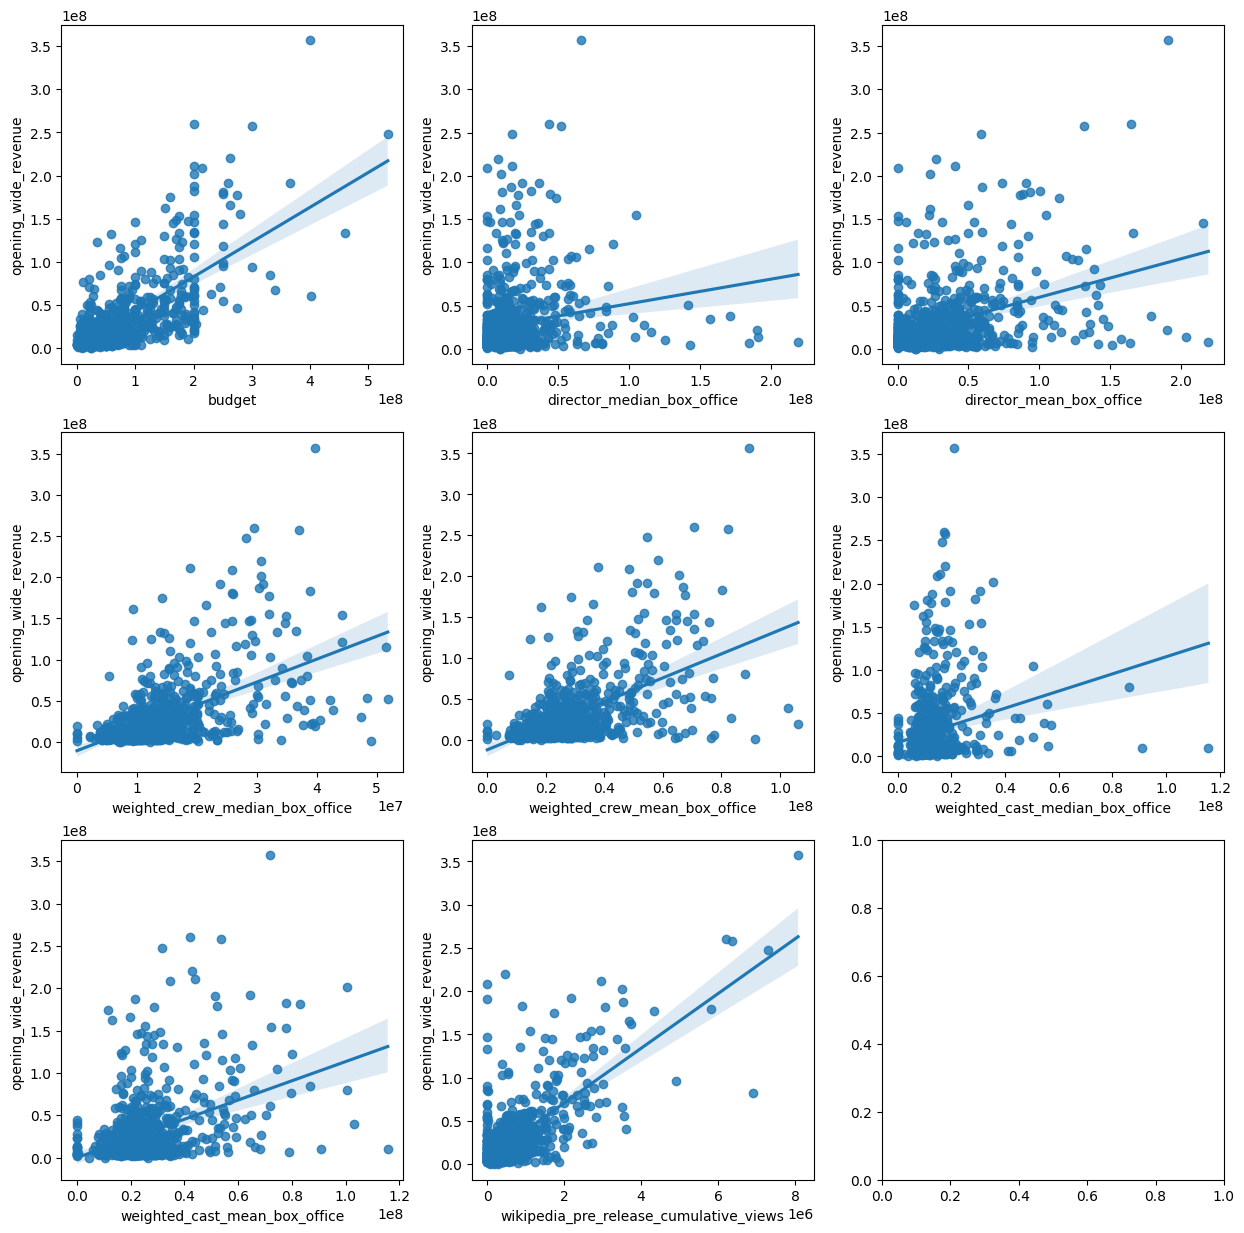

In [26]:
# the following are the features that lasso found as relevant, want to do exploratory analysis

# budget     0.272272
# 7               director_median_box_office    -0.114093
# 8                 director_mean_box_office     0.139005
# 9          weighted_crew_median_box_office     0.135436
# 10           weighted_crew_mean_box_office     0.112845
# 11         weighted_cast_median_box_office    -0.079282
# 12           weighted_cast_mean_box_office     0.145899
# 13  wikipedia_pre_release_cumulative_views     9.358108

# make a grid of scatter plots
fig, axs = plt.subplots(3, 3, figsize=(15, 15))

# budget vs opening_wide_revenue
sns.regplot(x='budget', y='opening_wide_revenue', data=df, ax=axs[0, 0])

# director_median_box_office vs opening_wide_revenue
sns.regplot(x='director_median_box_office', y='opening_wide_revenue', data=df, ax=axs[0, 1])

# director_mean_box_office vs opening_wide_revenue
sns.regplot(x='director_mean_box_office', y='opening_wide_revenue', data=df, ax=axs[0, 2])

# weighted_crew_median_box_office vs opening_wide_revenue
sns.regplot(x='weighted_crew_median_box_office', y='opening_wide_revenue', data=df, ax=axs[1, 0])

# weighted_crew_mean_box_office vs opening_wide_revenue
sns.regplot(x='weighted_crew_mean_box_office', y='opening_wide_revenue', data=df, ax=axs[1, 1])

# weighted_cast_median_box_office vs opening_wide_revenue
sns.regplot(x='weighted_cast_median_box_office', y='opening_wide_revenue', data=df, ax=axs[1, 2])

# weighted_cast_mean_box_office vs opening_wide_revenue
sns.regplot(x='weighted_cast_mean_box_office', y='opening_wide_revenue', data=df, ax=axs[2, 0])

# wikipedia_pre_release_cumulative_views vs opening_wide_revenue
sns.regplot(x='wikipedia_pre_release_cumulative_views', y='opening_wide_revenue', data=df, ax=axs[2, 1])

In [27]:
# gam
from pygam import LinearGAM

# print(X_train_dummies.columns)

relevant_features = ['budget', 'director_median_box_office', 'director_mean_box_office', 'weighted_crew_median_box_office', 'weighted_crew_mean_box_office', 'weighted_cast_mean_box_office', 'wikipedia_pre_release_cumulative_views', 'genre_Horror', 'mpaa_rating_PG-13', 'mpaa_rating_R', 'source_Original Screenplay', 'production_method_Digital Animation', 'distributor_slug_Sony-Pictures', 'distributor_slug_Warner-Bros', 'running_time']

X_train_gam = X_train_dummies[relevant_features]

gam = LinearGAM().fit(X_train_gam, y_train)

print(gam.summary())

LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                      83.309
Link Function:                     IdentityLink Log Likelihood:                                -25324.1469
Number of Samples:                          737 AIC:                                            50816.9117
                                                AICc:                                           50838.9845
                                                GCV:                                    418116919073250.44
                                                Scale:                                  334007135146024.94
                                                Pseudo R-Squared:                                   0.8074
Feature Function                  Lam

/tmp/ipykernel_11527/3798187377.py:12: UserWarning:

KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 




In [28]:
# plot actual vs predicted
y_pred_gam = gam.predict(X_test[relevant_features])

results_df_gam = pd.DataFrame({'predicted': y_pred_gam, 'actual': y_test})

# now add in X_test title, source, distributor, genre, creative_type, production_method, mpaa_rating, and release_day
results_df_gam['title'] = X_test['title']
results_df_gam['source'] = X_test['source']
results_df_gam['distributor_slug'] = X_test['distributor_slug']
results_df_gam['genre'] = X_test['genre']
results_df_gam['creative_type'] = X_test['creative_type']
results_df_gam['production_method'] = X_test['production_method']
results_df_gam['mpaa_rating'] = X_test['mpaa_rating']
results_df_gam['release_day'] = X_test['release_day']

results_df_gam['predicted'] = results_df_gam['predicted'] / 1000000

results_df_gam['actual'] = results_df_gam['actual'] / 1000000

# results_df_gam.to_csv('gam_results.csv', index=False)
import plotly.express as px
import plotly.graph_objects as go

# Create the scatter plot
fig = px.scatter(
    results_df_gam,
    x='actual',
    y='predicted',
    color='mpaa_rating',
    labels={
        'actual': 'Actual Opening Weekend Revenue (Millions)',
        'predicted': 'Predicted Opening Weekend Revenue (Millions)'
    },
    title='Actual vs Predicted Opening Weekend Revenue',
    hover_name='title'
)

# Add the diagonal line
fig.add_trace(
    go.Scatter(
        x=[0, 200],
        y=[0, 200],
        mode='lines',
        line=dict(color='red'),
        showlegend=False
    )
)

# Show the plot
fig.show()

In [30]:
relevant_features = [
    "budget",
    # "director_median_box_office",
    # "director_mean_box_office",
    "weighted_crew_median_box_office",
    # "weighted_crew_mean_box_office",
    "weighted_cast_mean_box_office",
    "wikipedia_pre_release_cumulative_views",
    # "wikipedia_pre_release_monday_views",
    # "wikipedia_pre_release_week_monday",
    # "wikipedia_pre_release_three_monday",
    # "genre_Horror",
    # "mpaa_rating_PG-13",
    # "mpaa_rating_R",
    # "source_Original Screenplay",
    # "production_method_Digital Animation",
    # "distributor_slug_Sony-Pictures",
    # "distributor_slug_Warner-Bros",
    "running_time",
    # "metacritic_score",
    "in_franchise",
    # "metacritic_review_count",
    # "metacritic_score_calculated",
    # "metacritic_monday_before_wide_friday_calculated",
    "metacritic_before_wide_friday_calculated",
    # "metacritic_before_first_day_calculated"
]

# make an MLR with these features
X_train_mlr = X_train_dummies[relevant_features]

model_mlr = OLS(y_train, X_train_mlr)

results_mlr = model_mlr.fit()

print(results_mlr.summary2(float_format=millions))

                                       Results: Ordinary least squares
Model:                           OLS                          Adj. R-squared (uncentered):         0.803     
Dependent Variable:              opening_wide_revenue         AIC:                                 26972.1447
Date:                            2024-11-02 17:42             BIC:                                 27004.3629
No. Observations:                737                          Log-Likelihood:                      -13479.   
Df Model:                        7                            F-statistic:                         430.2     
Df Residuals:                    730                          Prob (F-statistic):                  3.94e-254 
R-squared (uncentered):          0.805                        Scale:                               4.5435e+14
-------------------------------------------------------------------------------------------------------------
                                             Coef

In [31]:
# graph actual vs predicted
y_pred_mlr = results_mlr.predict(X_test[relevant_features])

results_df_mlr = pd.DataFrame({'predicted': y_pred_mlr, 'actual': y_test})

results_df_mlr['predicted'] = results_df_mlr['predicted'] / 1000000
results_df_mlr['actual'] = results_df_mlr['actual'] / 1000000
results_df_mlr['title'] = X_test['title']
results_df_mlr['source'] = X_test['source']
results_df_mlr['distributor_slug'] = X_test['distributor_slug']
results_df_mlr['genre'] = X_test['genre']
results_df_mlr['creative_type'] = X_test['creative_type']
results_df_mlr['production_method'] = X_test['production_method']
results_df_mlr['mpaa_rating'] = X_test['mpaa_rating']

# results_df_mlr.to_csv('mlr_results.csv', index=False)

# Create the scatter plot
fig = px.scatter(
    results_df_mlr,
    x='actual',
    y='predicted',
    color='mpaa_rating',
    labels={
        'actual': 'Actual Opening Weekend Revenue (Millions)',
        'predicted': 'Predicted Opening Weekend Revenue (Millions)'
    },
    title='Actual vs Predicted Opening Weekend Revenue',
    hover_name='title'
)

# Add the diagonal line
fig.add_trace(
    go.Scatter(
        x=[0, 200],
        y=[0, 200],
        mode='lines',
        line=dict(color='red'),
        showlegend=False
    )
)

# Show the plot
fig.show()

In [87]:
# glm with metacritic interactions
from statsmodels.api import GLM
import statsmodels.formula.api as smf

# combine x train and y train
glm_df = X_train_dummies.copy()
glm_df["opening_wide_revenue"] = y_train

formula = "opening_wide_revenue ~ 0 + budget + weighted_crew_median_box_office + weighted_cast_mean_box_office + wikipedia_pre_release_cumulative_views + metacritic_before_wide_friday_calculated + in_franchise : wikipedia_pre_release_cumulative_views + running_time"

# "metacritic_review_count",
    # "metacritic_score_calculated",
    # "metacritic_monday_before_wide_friday_calculated",
    # "metacritic_before_wide_friday_calculated",
    # "metacritic_before_first_day_calculated"

# add in the interactions
model = smf.glm(formula=formula, data=glm_df).fit()

pred_glm = model.predict(X_test)

print('RMSE:', root_mean_squared_error(y_test, pred_glm))
print(model.summary())

RMSE: 26340176.846463595
                  Generalized Linear Model Regression Results                   
Dep. Variable:     opening_wide_revenue   No. Observations:                  737
Model:                              GLM   Df Residuals:                      730
Model Family:                  Gaussian   Df Model:                            6
Link Function:                 Identity   Scale:                      4.3406e+14
Method:                            IRLS   Log-Likelihood:                -13462.
Date:                  Sat, 02 Nov 2024   Deviance:                   3.1686e+17
Time:                          17:56:22   Pearson chi2:                 3.17e+17
No. Iterations:                       3   Pseudo R-squ. (CS):             0.9221
Covariance Type:              nonrobust                                         
                                                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------

In [88]:
# print actual vs predicted

results_df_glm = pd.DataFrame({'predicted': pred_glm, 'actual': y_test})

results_df_glm['predicted'] = results_df_glm['predicted'] / 1000000
results_df_glm['actual'] = results_df_glm['actual'] / 1000000
results_df_glm['title'] = X_test['title']
results_df_glm['source'] = X_test['source']
results_df_glm['distributor_slug'] = X_test['distributor_slug']
results_df_glm['genre'] = X_test['genre']
results_df_glm['creative_type'] = X_test['creative_type']
results_df_glm['production_method'] = X_test['production_method']
results_df_glm['mpaa_rating'] = X_test['mpaa_rating']

# results_df_glm.to_csv('glm_results.csv', index=False)

# Create the scatter plot
fig = px.scatter(
    results_df_glm,
    x='actual',
    y='predicted',
    color='distributor_slug',
    labels={
        'actual': 'Actual Opening Weekend Revenue (Millions)',
        'predicted': 'Predicted Opening Weekend Revenue (Millions)'
    },
    title='Actual vs Predicted Opening Weekend Revenue',
    hover_name='title'
)

# Add the diagonal line
fig.add_trace(
    go.Scatter(
        x=[0, 200],
        y=[0, 200],
        mode='lines',
        line=dict(color='red'),
        showlegend=False
    )
)

# Show the plot
fig.show()

In [75]:
# make some basic mlr
relevant_features = ["budget"]
X_train_basic1 = X_train_dummies[relevant_features]
model_mlr = OLS(y_train, X_train_basic1)
results_mlr = model_mlr.fit()
basic1_pred = results_mlr.predict(X_test[relevant_features])

relevant_features = ["budget", "weighted_crew_median_box_office"]
X_train_basic2 = X_train_dummies[relevant_features]
model_mlr = OLS(y_train, X_train_basic2)
results_mlr = model_mlr.fit()
basic2_pred = results_mlr.predict(X_test[relevant_features])

relevant_features = ["budget", "weighted_crew_median_box_office", "wikipedia_pre_release_cumulative_views"]
X_train_basic3 = X_train_dummies[relevant_features]
model_mlr = OLS(y_train, X_train_basic3)
results_mlr = model_mlr.fit()
basic3_pred = results_mlr.predict(X_test[relevant_features])

In [76]:
# calculate the mse for each model

mse_lasso = root_mean_squared_error(y_test, y_pred)
mse_gam = root_mean_squared_error(y_test, y_pred_gam)
mse_mlr = root_mean_squared_error(y_test, y_pred_mlr)
mse_glm = root_mean_squared_error(y_test, pred_glm)
mse_basic1 = root_mean_squared_error(y_test, basic1_pred)
mse_basic2 = root_mean_squared_error(y_test, basic2_pred)
mse_basic3 = root_mean_squared_error(y_test, basic3_pred)

print('Lasso RMSE:', mse_lasso)
print('GAM RMSE:', mse_gam)
print('MLR RMSE:', mse_mlr)
print('GLM RMSE:', mse_glm)
print('Basic1 RMSE:', mse_basic1)
print('Basic2 RMSE:', mse_basic2)
print('Basic3 RMSE:', mse_basic3)

Lasso RMSE: 35752419.63868792
GAM RMSE: 37000853.14660594
MLR RMSE: 28134417.02056215
GLM RMSE: 25871637.595556125
Basic1 RMSE: 36242121.78264017
Basic2 RMSE: 34891367.42421532
Basic3 RMSE: 30860836.13585527
